# Reinforcements Learning with Human Feedback

## Notes

## References

[Cartpole RLHF in Gym](https://www.analyticsvidhya.com/blog/2023/05/enhancing-rlhf-using-openai-and-tensorflow/)


# Imports


In [8]:
import pandas as pd, numpy as np
import gym
import tensorflow as tf
from tqdm.notebook import trange, tqdm
from matplotlib import pyplot as plt

%matplotlib inline
tf.get_logger().setLevel("ERROR")

# Agent


In [6]:
class RLHFAgent:
    def __init__(self, env):
        self.env = env
        self.n_observations = env.observation_space.shape[0]
        self.n_actions = env.action_space.n
        self.model = self.build_model()

    def build_model(self):
        """Build a neural network model that maps observations to actions."""
        model = tf.keras.Sequential(
            [
                tf.keras.layers.Dense(
                    16, activation="relu", input_shape=(self.n_observations,)
                ),
                tf.keras.layers.Dense(16, activation="relu"),
                tf.keras.layers.Dense(self.n_actions, activation="softmax"),
            ]
        )
        model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
            loss="categorical_crossentropy",
            metrics=["accuracy"],
        )
        return model

    def generate_action(self, observation):
        """Generate an action based on the observation.
        Different policies can be used here."""
        observation = np.reshape(observation, [1, self.n_observations])
        action_probabilities = self.model.predict(observation)[0]
        # takes a random action with probability proportional to its probability
        action = np.random.choice(self.n_actions, p=action_probabilities)
        return action

    def update_policy(self, observation, action, feedback):
        """Update the policy based on the feedback.
        Here this means we update the model that predicts actions from observations."""
        observation = np.reshape(observation, [1, self.n_observations])
        action_probabilities = self.model.predict(observation)[0]
        action_mask = np.zeros(self.n_actions)
        action_mask[action] = 1
        feedback = np.array([feedback])
        X = observation
        y = feedback * (action_mask - action_probabilities)
        y = np.reshape(y, (1, self.n_actions))
        loss = self.model.train_on_batch(X, y)
        return loss

    def feedback_from_reward_model(self, observation, action):
        """Get feedback from the user."""
        if observation[0] < -0.5 or observation[0] > 0.5:
            return 0
        else:
            return 100

    def run_episode(self, render=False):
        observation, info = self.env.reset()

        terminated = False
        total_reward = 0
        step = 0
        while not terminated:
            step += 1
            action = self.generate_action(observation)
            observation, reward, terminated, truncated, info = self.env.step(action)
            plt.imshow(self.env.render())
            total_reward += reward
            # feedback = int(input("was the action good? (0/1)"))
            feedback = self.feedback_from_reward_model(observation, action)
            loss = self.update_policy(observation, action, feedback)
        return total_reward

In [9]:
env = gym.make("CartPole-v0", render_mode="rgb_array")

agent = RLHFAgent(env)
n_episodes = 100
episodic_rewards = []
for i in trange(n_episodes):
    total_reward = agent.run_episode()
    episodic_rewards.append(total_reward)

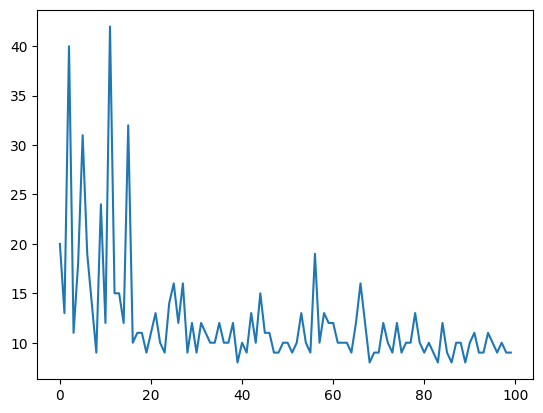

In [10]:
plt.plot(episodic_rewards);